In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib.text as mtext
from matplotlib.colors import TwoSlopeNorm
import textwrap
from core import med_log_odds_cutoff, bw_color_palette
import numpy as np
from tqdm import tqdm

In [3]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
def assign_proto_category(row):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['defense_homolog']:
        return 'Defense homolog in new context'
    else:
        return 'Putative novel defense gene'

In [5]:
def assign_hit_category(row):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['defense_homolog']:
        return 'Defense homolog in new context'
    elif row['q_cov'] > 0.4:
        return 'Remote defense homolog'
    else:
        return 'Predicted novel defense gene'

In [6]:
def select_domains(hhblits_df, prob_cutoff=50):
    # Other Domains
    out_list = []
    filt_df = hhblits_df[(hhblits_df['Prob'] > prob_cutoff)]
    for group, group_df in tqdm(filt_df.groupby('query'), 
                                position=0, total=filt_df['query'].nunique()):
        group_df = group_df.sort_values('Prob', ascending=False)
        while len(group_df):
            selected_row = group_df.head(1).squeeze()
            out_list.append(selected_row)
            group_df = group_df[(group_df['qend'] < selected_row['qstart']) |
                                (group_df['qstart'] > selected_row['qend'])]
    selected_domain_df = pd.concat(out_list, axis=1).T
    return selected_domain_df

In [7]:
predictions = pd.read_parquet('../data3/processed/ecoli_3k_predictions.pq')
hhpred_results = pd.read_csv('../data3/interim/ecoli_3k_putative_novel_pfam_df_domains.csv')
blacklisted_domains = pd.read_csv('../data3/interim/df_blacklisted_domains.csv')
pfam_clans = pd.read_table('../data/raw/Pfam-A.clans.tsv', 
                           names=['pfam_id', 'clan_id', 'clan_name', 'pfam_name', 'pfam_description'])

In [8]:
putative_novel_ids = list()
for line in open('../data3/interim/ecoli_3k_putative_novel_seqs.faa'):
    if line.startswith('>'):
        putative_novel_ids.append(line[1:])

In [9]:
len(putative_novel_ids)

1926

In [10]:
proto_categories = ['Defense homolog in expected system',
                  'Defense homolog in new context', 
                  'Putative novel defense gene']
filtered_predictions = predictions[predictions['mean_log_odds'] > med_log_odds_cutoff].copy()
filtered_predictions['proto_category'] = filtered_predictions.apply(assign_proto_category, axis=1)
filtered_predictions['proto_category'] = pd.Categorical(filtered_predictions['proto_category'], categories=proto_categories)

In [11]:
unique_filtered_predictions = (filtered_predictions.sort_values(['proto_category', 'mean_log_odds'], ascending=[True, False])
                             .groupby('cluster_id')
                             .head(1))

In [12]:
len(unique_filtered_predictions)

3660

In [13]:
hhpred_results['q_ali_len'] = hhpred_results['qend'] - hhpred_results['qstart']
remote_defense_homologs = (hhpred_results[hhpred_results['hit_name'].str.contains('~') &
                                          (hhpred_results['Prob'] > 50)]
                           .sort_values('q_ali_len', ascending=False)
                           .groupby('query')
                           .head(1)
                           .merge(filtered_predictions[['product_accession', 'product_length']].drop_duplicates(), 
                                  how='inner', left_on='query', right_on='product_accession'))
remote_defense_homologs['q_cov'] = remote_defense_homologs['q_ali_len']/remote_defense_homologs['product_length']

In [14]:
unique_filtered_predictions['proto_category'].value_counts()

proto_category
Putative novel defense gene           1926
Defense homolog in new context        1037
Defense homolog in expected system     697
Name: count, dtype: int64

In [15]:
merged_predictions = (unique_filtered_predictions.merge(
    remote_defense_homologs[['product_accession', 'hit_name', 'q_cov', 'Prob']], how='left', 
                                                   on='product_accession'))
merged_predictions['q_cov'] = merged_predictions['q_cov'].fillna(0)
merged_predictions['hit_category'] = merged_predictions.apply(assign_hit_category, axis=1)
merged_predictions['hit_category'] = pd.Categorical(merged_predictions['hit_category'], 
                                                    categories=['Defense homolog in expected system',
                                                                'Defense homolog in new context', 
                                                                'Remote defense homolog', 
                                                                'Predicted novel defense gene'])

In [16]:
merged_predictions['hit_category'].value_counts()

hit_category
Predicted novel defense gene          1209
Defense homolog in new context        1037
Remote defense homolog                 717
Defense homolog in expected system     697
Name: count, dtype: int64

In [17]:
genomes = predictions['assembly'].drop_duplicates()
len(genomes)

3000

In [18]:
n_boot = 10

In [19]:
sample_range = [int(x) for x in np.linspace(1, len(genomes), num=50)]
n_def_cluster_list = list()
for n in tqdm(sample_range):
    for boot in range(n_boot):
        sampled_genomes = set(genomes.sample(n=n, random_state=boot))
        sampled_clusters = set(predictions.loc[predictions['assembly'].isin(sampled_genomes), 'cluster_id'])
        sampled_def_df = merged_predictions[merged_predictions['cluster_id'].isin(sampled_clusters)]
        n_def_clusters = (sampled_def_df['hit_category']
                          .value_counts()
                          .reset_index())
        n_def_clusters['n_genomes'] = n
        n_def_clusters['boot'] = boot
        n_def_cluster_list.append(n_def_clusters)
cat_n_def_cluster = pd.concat(n_def_cluster_list)

100%|██████████| 50/50 [10:21<00:00, 12.43s/it]


In [20]:
agg_n_def_cluster = (cat_n_def_cluster.groupby(['hit_category', 'n_genomes'])
                     .agg({'count': 'mean'})
                     .reset_index())

In [21]:
agg_n_def_cluster['hit_category'] = pd.Categorical(agg_n_def_cluster['hit_category'], 
                                                         categories=['Defense homolog in expected system', 
                                                                     'Defense homolog in new context', 
                                                                     'Remote defense homolog', 
                                                                     'Predicted novel defense gene'])

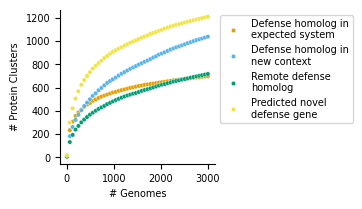

In [22]:
plt.subplots(figsize=(2, 2))
sns.scatterplot(data=agg_n_def_cluster, x='n_genomes', y='count', hue='hit_category',
              palette=bw_color_palette[:4], s=10)
sns.despine()
# Adjust legend
legend = plt.legend(loc="upper left", bbox_to_anchor=(1,1))
handles, labels = legend.get_texts(), [text.get_text() for text in legend.get_texts()]
wrapped_labels = [textwrap.fill(label, 20) for label in labels]
for text, wrapped_label in zip(handles, wrapped_labels):
    text.set_text(wrapped_label)
# Other plot attributes
plt.ylabel('# Protein Clusters')
plt.xlabel('# Genomes')
plt.savefig('../figures/ecoli3k_predicted_category_per_genome.svg', dpi=300, bbox_inches='tight')

In [23]:
merged_predictions.to_parquet('../data3/interim/ecoli3k_predicted_defense.pq', index=False)

In [1]:
import pandas as pd
import os
from tqdm import tqdm

In [2]:
merged_predictions = pd.read_parquet('../data3/interim/ecoli3k_predicted_defense.pq')

In [5]:
merged_predictions.columns

Index(['protein_context_id', 'mean_log_odds', 'sd_log_odds', 'min_log_odds',
       'max_log_odds', '# feature', 'class', 'assembly', 'assembly_unit',
       'seq_type', 'genomic_accession', 'start', 'end', 'strand',
       'product_accession', 'non-redundant_refseq', 'related_accession',
       'name', 'symbol', 'GeneID', 'locus_tag', 'feature_interval_length',
       'product_length', 'attributes', 'predicted_defensive', 'assembly_stub',
       'defense_homolog_name', 'defense_homolog', 'defense_system_gene',
       'defense_system', 'defense_system_protein', 'cluster_id',
       'proto_category', 'hit_name', 'q_cov', 'Prob', 'hit_category'],
      dtype='object')

In [6]:
novel_acc_out = '../data3/interim/ecoli_3k_put_novel_accessions.txt'


In [7]:
merged_predictions.query("hit_category == 'Predicted novel defense gene'")['product_accession'].to_csv(novel_acc_out, index=False, header=False)

In [8]:
faa_out = '../data3/interim/ecoli_3k_put_novel_seqs.faa'


In [9]:
os.system(' '.join(['conda run -n beaker', 
                    'seqtk subseq', '../data/ecoli/interim/unique_seqs.faa', 
                    novel_acc_out, '>',
                    faa_out]))

0

## Get new domains

In [24]:
pfam_hhpred_results = hhpred_results[hhpred_results['hit_name'].str.startswith('PF')]

In [25]:
select_pfam = select_domains(pfam_hhpred_results)

100%|██████████| 1485/1485 [00:01<00:00, 787.42it/s]


In [26]:
select_pfam['pfam_id'] = select_pfam['hit_name'].str.split('.', expand=True)[0]
select_pfam = select_pfam.merge(pfam_clans, how='inner', on='pfam_id')

In [27]:
filtered_pfam = select_pfam[~select_pfam['pfam_id'].isin(blacklisted_domains['pfam_id'].unique()) & 
                            ~select_pfam['clan_id'].isin(blacklisted_domains['clan_id'].dropna().unique())]

In [28]:
filtered_pfam['pfam_id'].nunique()

253

In [29]:
merged_pfam = (filtered_pfam
               .merge(predictions[['product_accession', 'mean_log_odds', 'protein_context_id']]
                      .rename(columns={'product_accession': 'query'}), 
                      how='inner', on='query'))
merged_pfam['defense_prob'] = 1/(1 + np.exp(-merged_pfam['mean_log_odds']))
merged_pfam['combined_prob'] = (merged_pfam['Prob']/100) * (merged_pfam['defense_prob'])

In [30]:
top_pfam = (merged_pfam.sort_values('combined_prob', ascending=False)
            .groupby('pfam_id')
            .head(1))

In [31]:
len(top_pfam)

253

In [32]:
top_pfam.to_csv('../data3/interim/ecoli_3k_putative_novel_pfam.csv', index=False)

In [33]:
top_pfam_annot = pd.read_csv('../data3/external/ecoli_3k_putative_novel_pfam_annot.csv')
top_pfam_annot['Potentially interesting'] = top_pfam_annot['Potentially interesting'].fillna(False)

In [34]:
filtered_pfam = top_pfam_annot[top_pfam_annot['Potentially interesting']]

In [35]:
len(filtered_pfam)

32

In [36]:
sorted_predictions = (predictions.sort_values(['genomic_accession', 
                                               'start'], ascending=False)
                      .reset_index(drop=True))

In [37]:
n_neighbors = 5

In [38]:
norm = TwoSlopeNorm(vmin=predictions['mean_log_odds'].min(), 
                    vcenter=0, 
                    vmax=predictions['mean_log_odds'].max())
cmap = plt.get_cmap('RdBu_r')

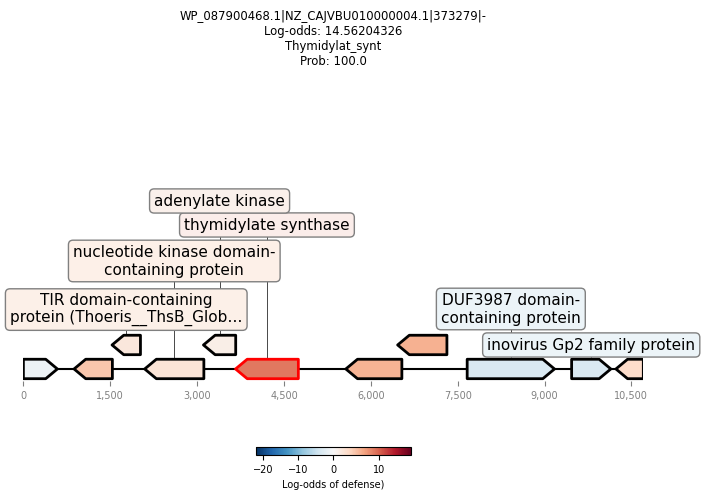

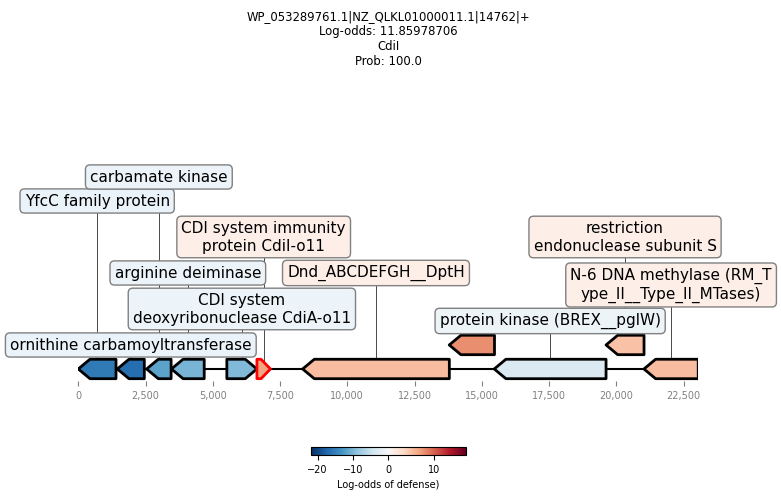

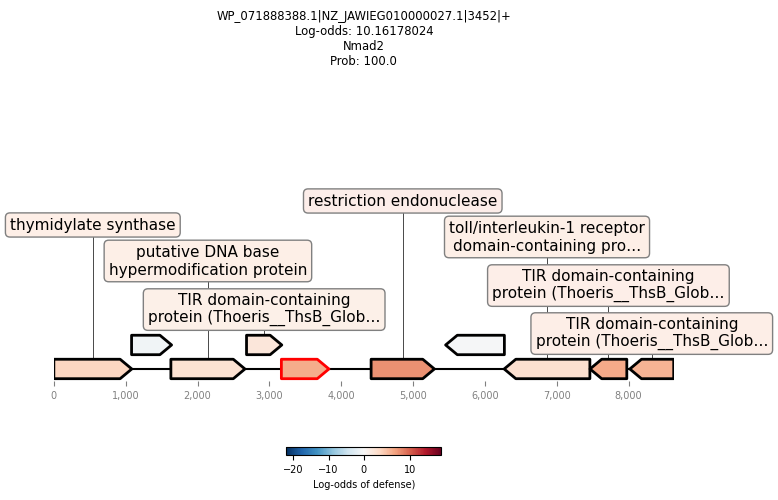

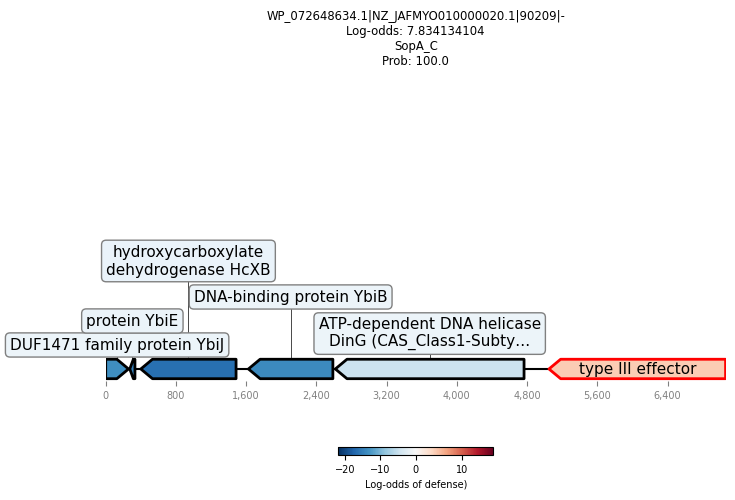

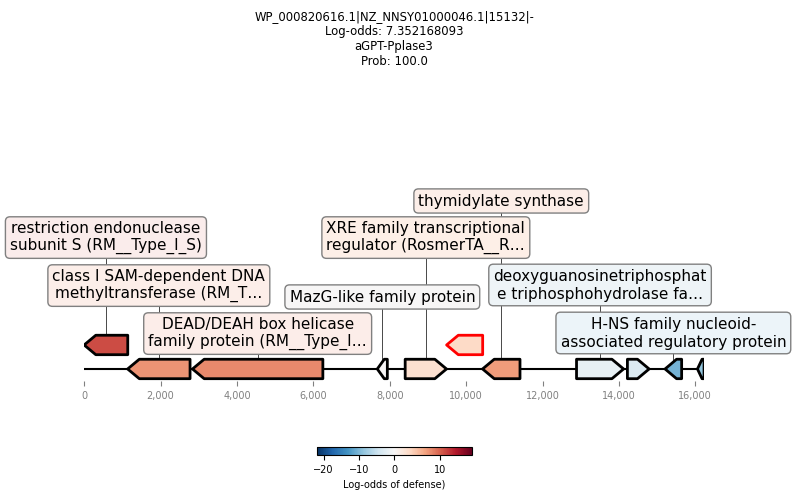

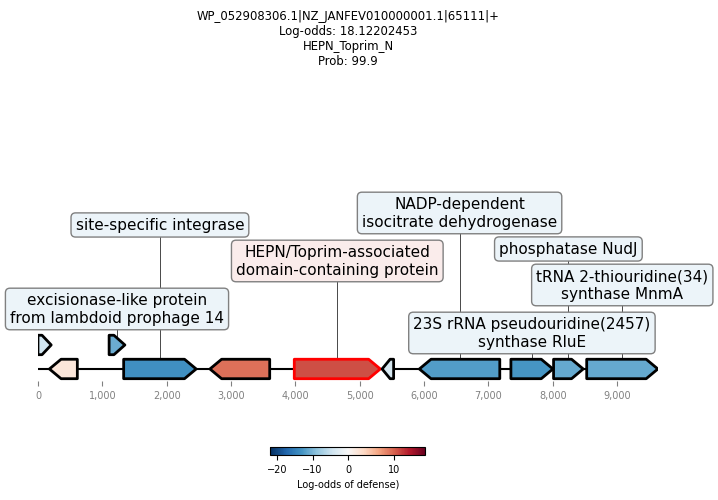

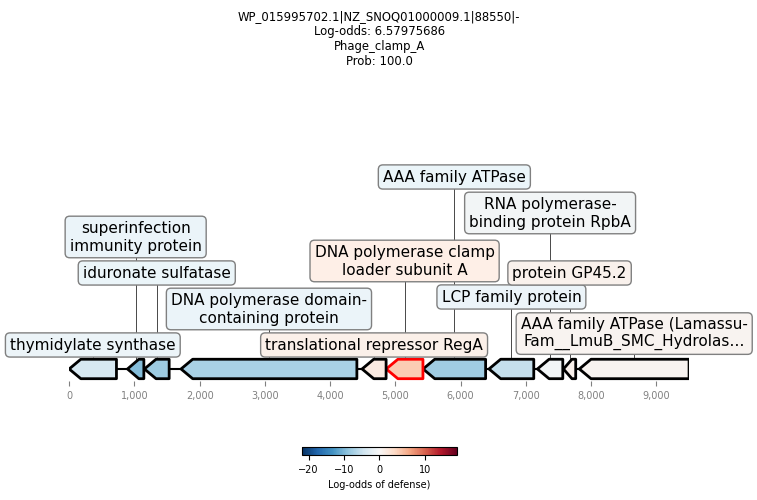

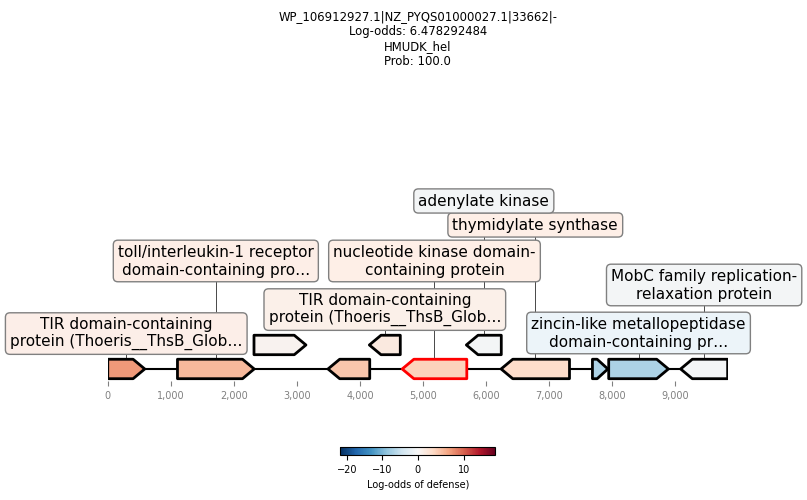

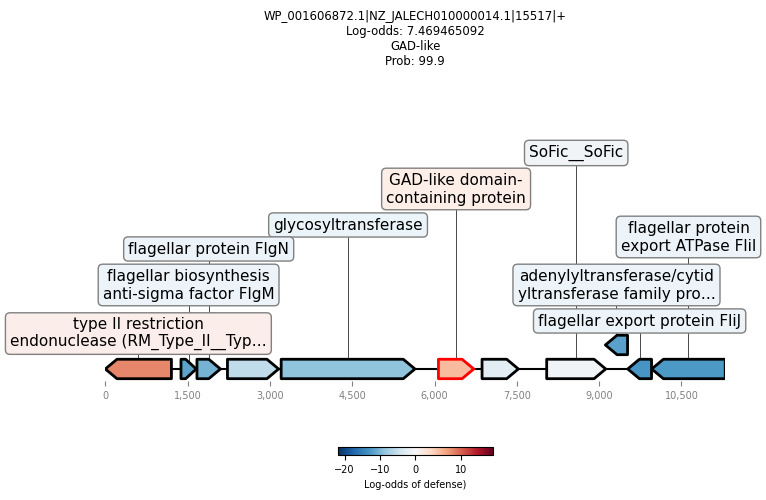

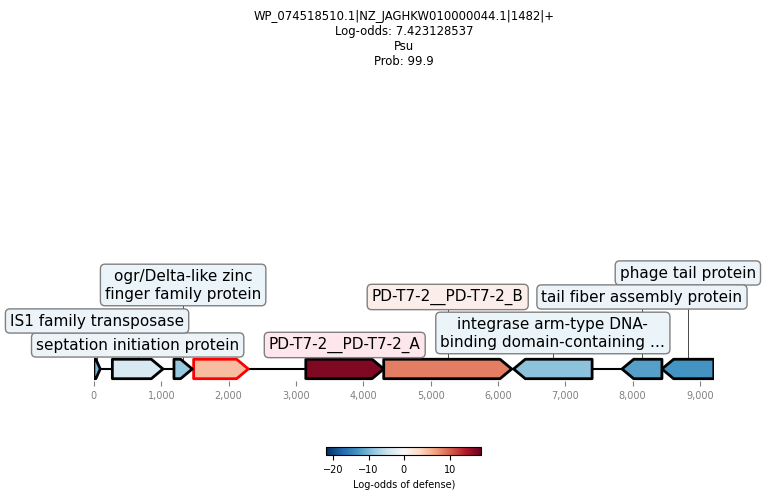

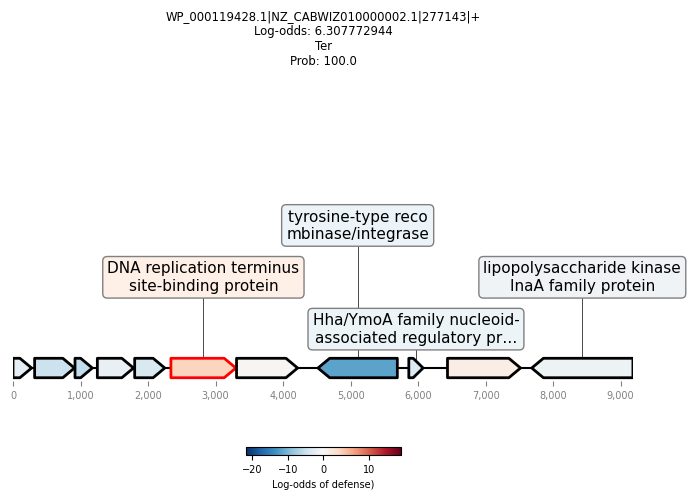

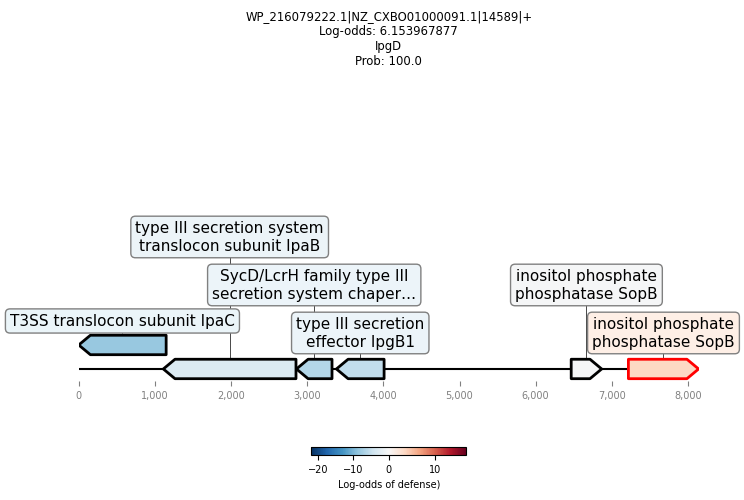

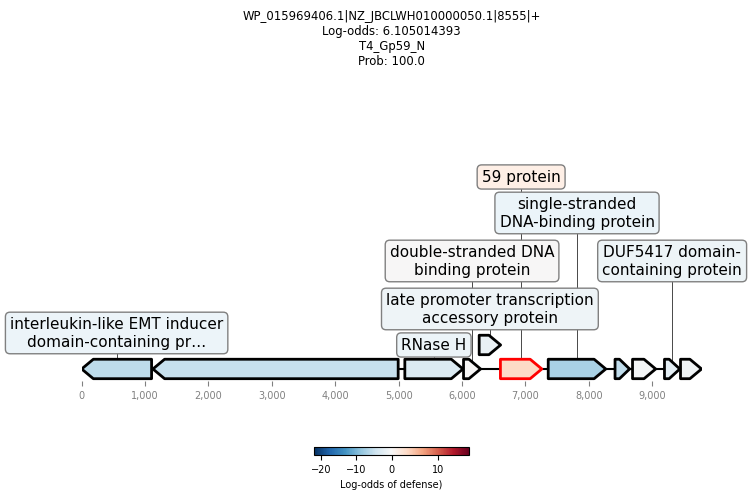

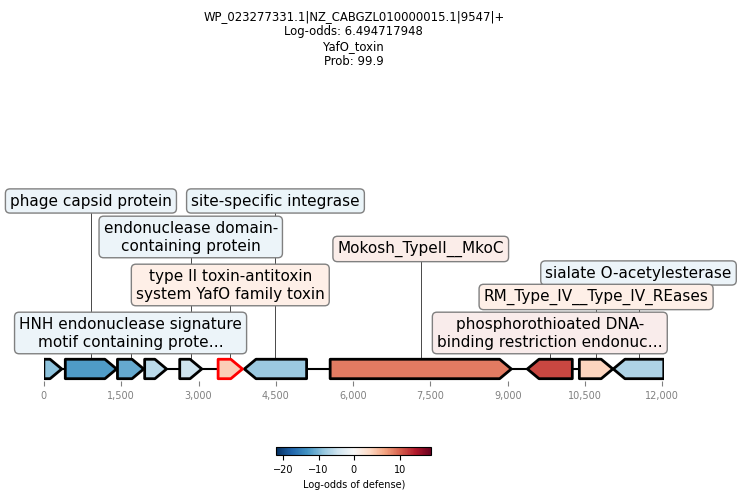

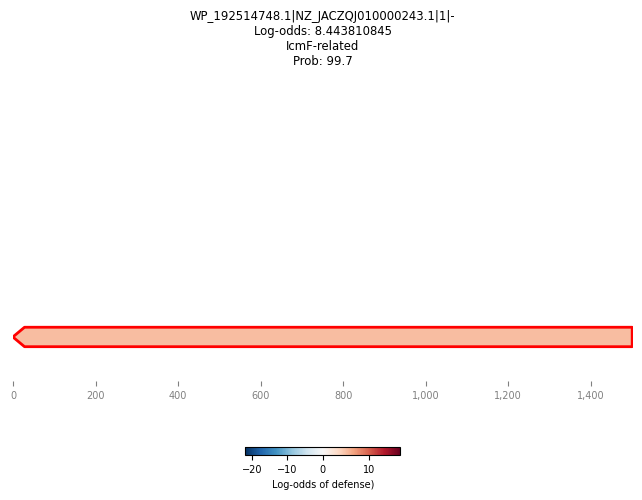

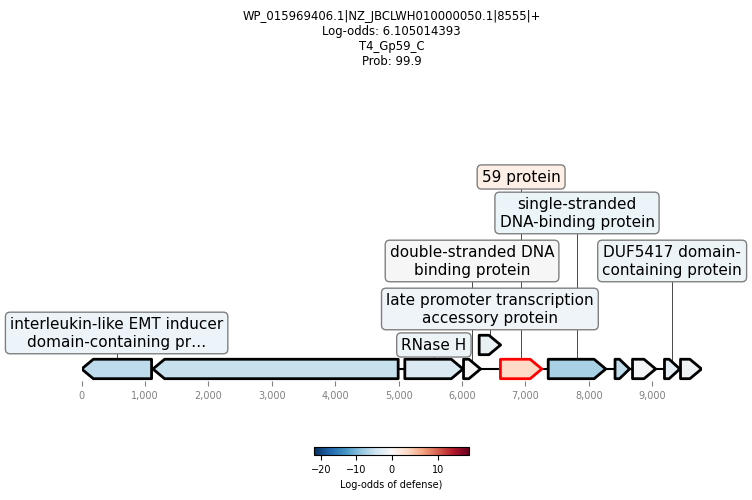

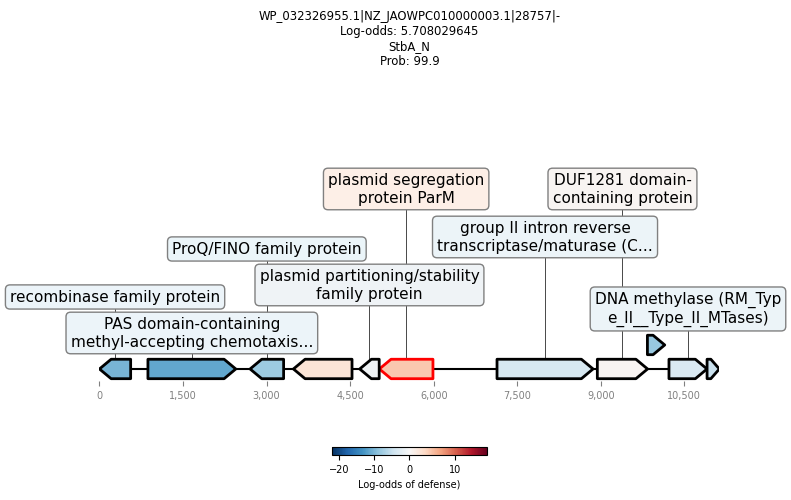

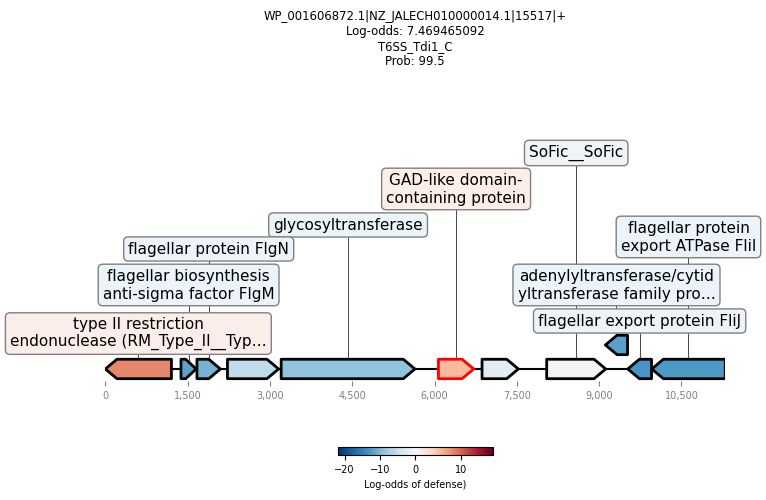

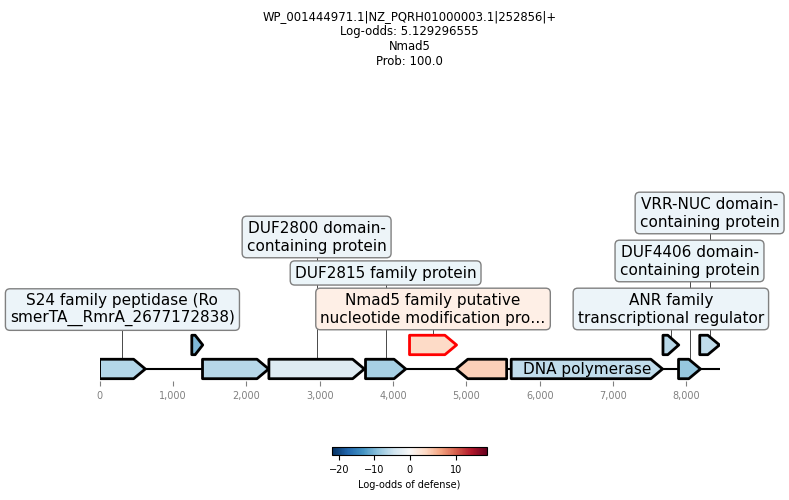

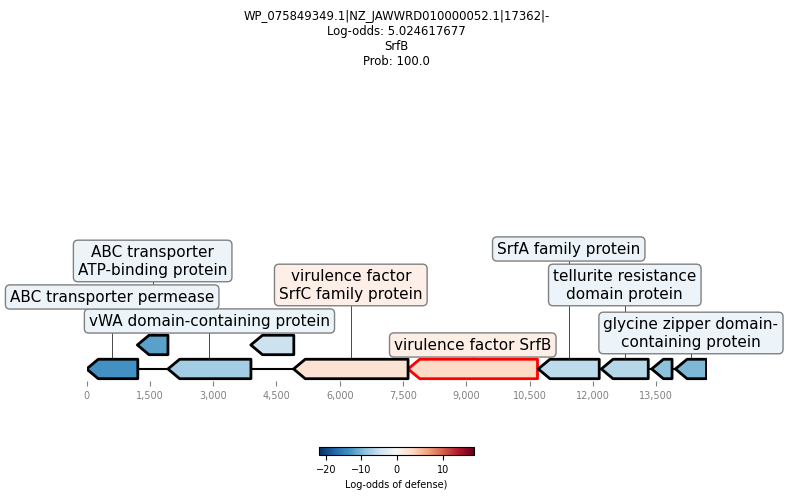

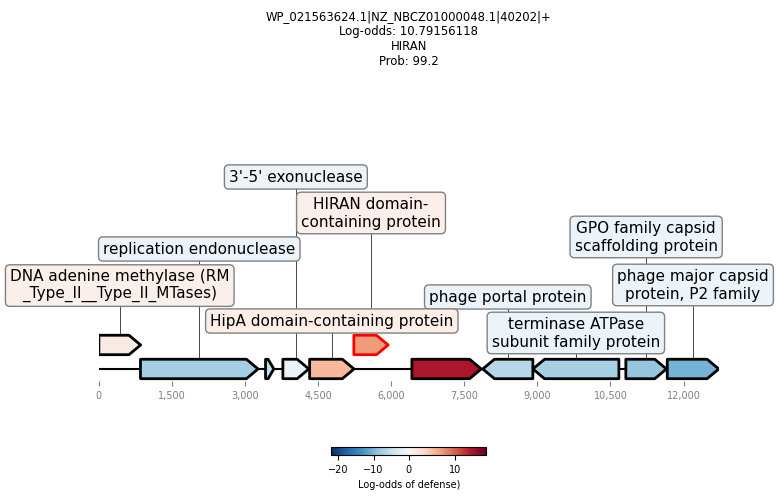

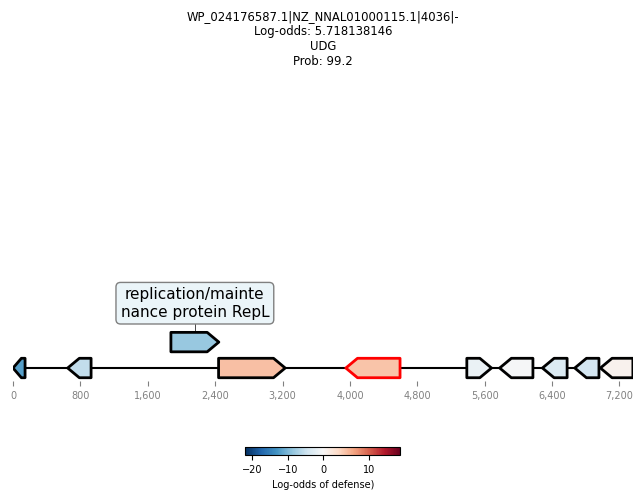

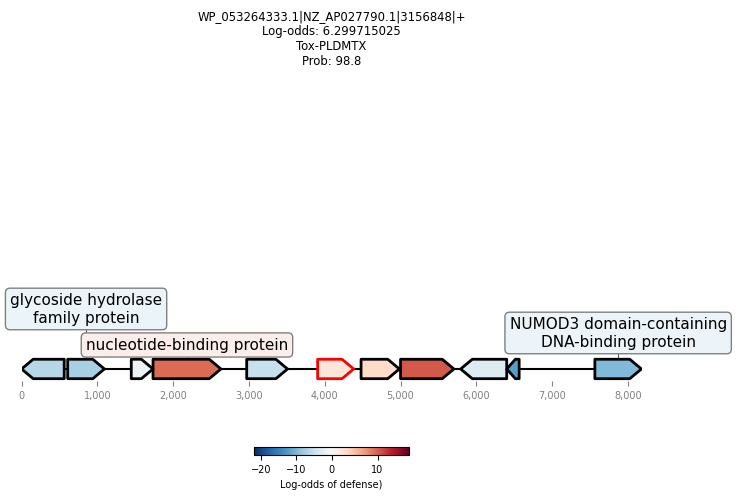

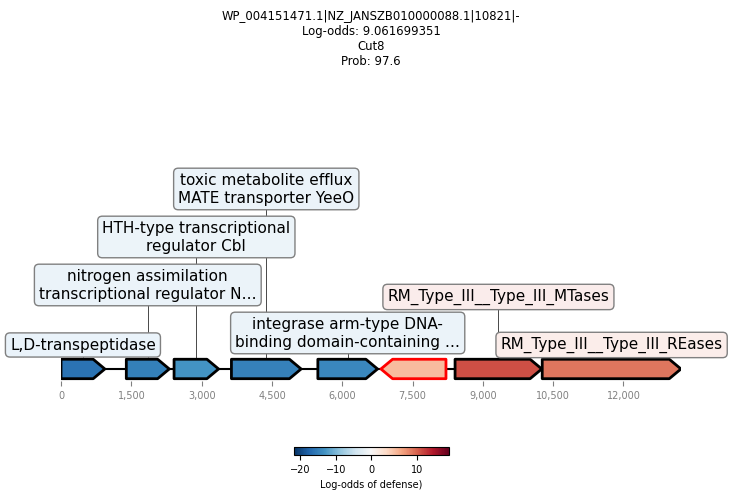

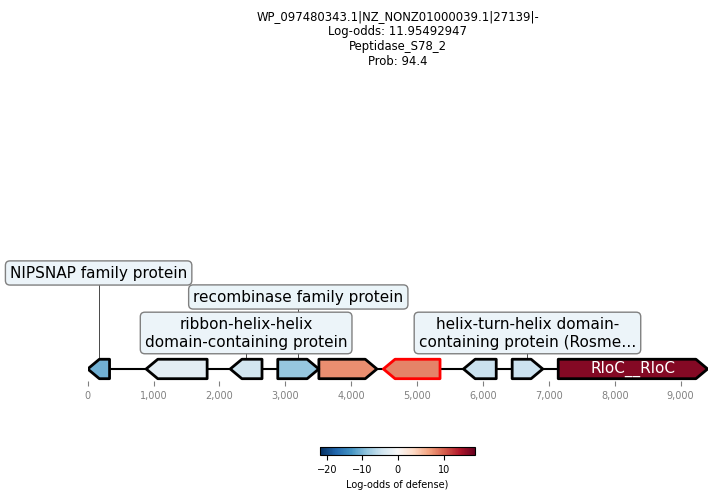

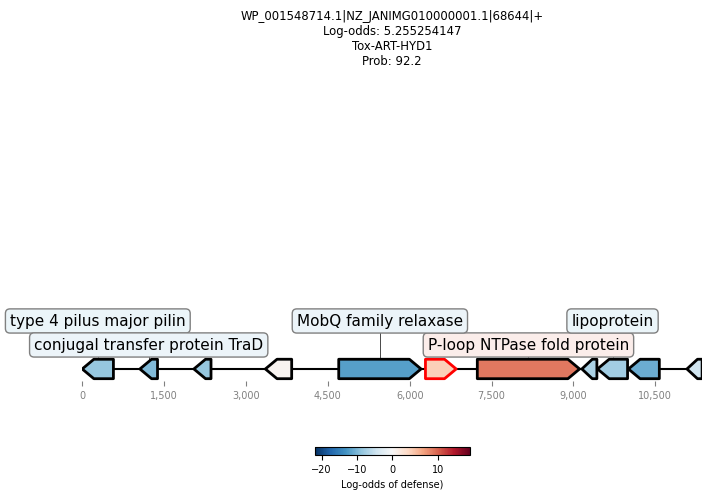

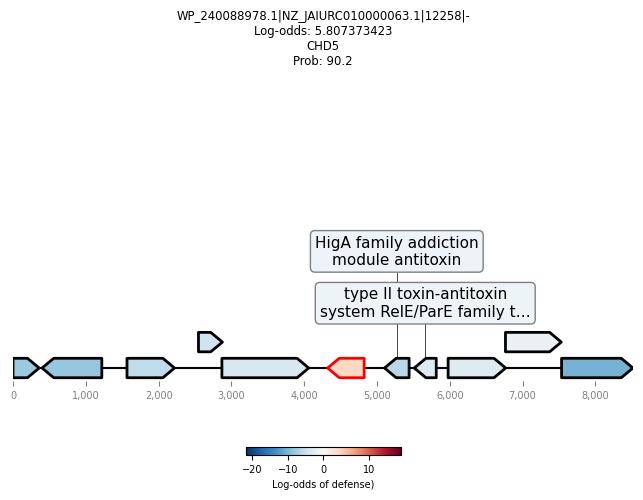

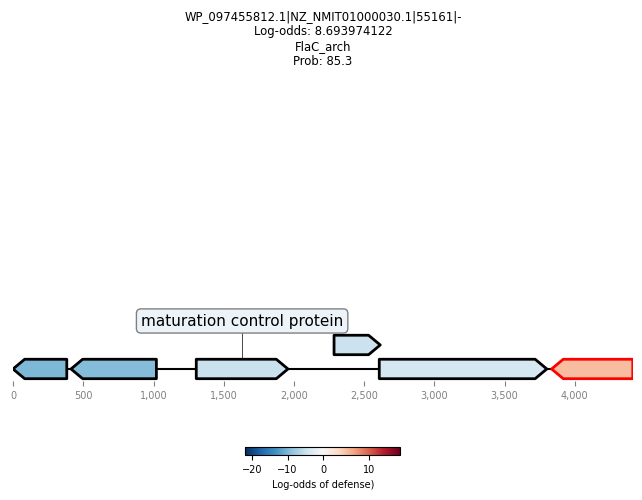

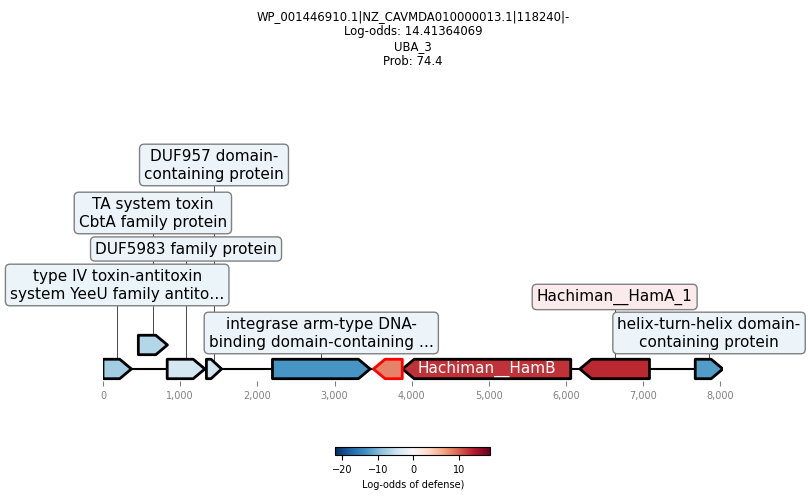

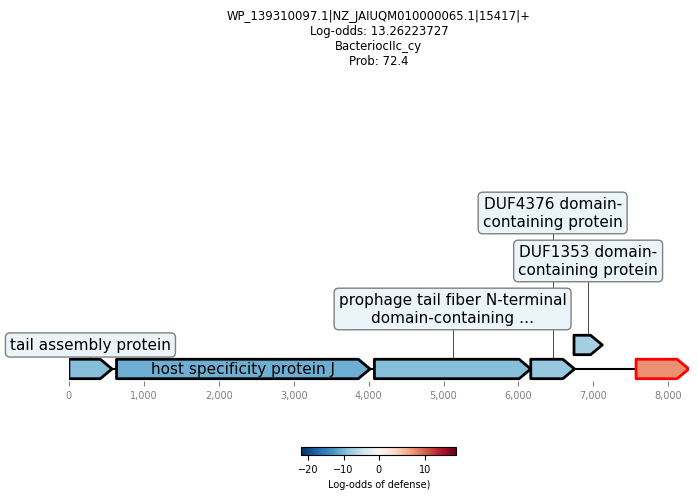

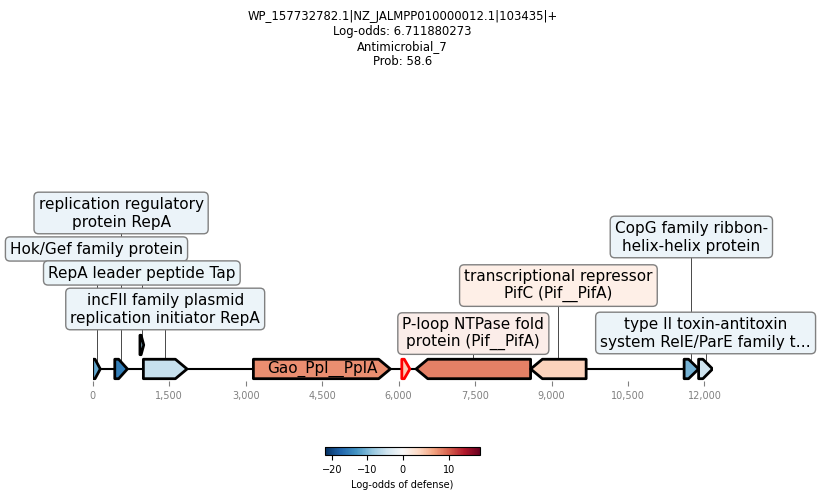

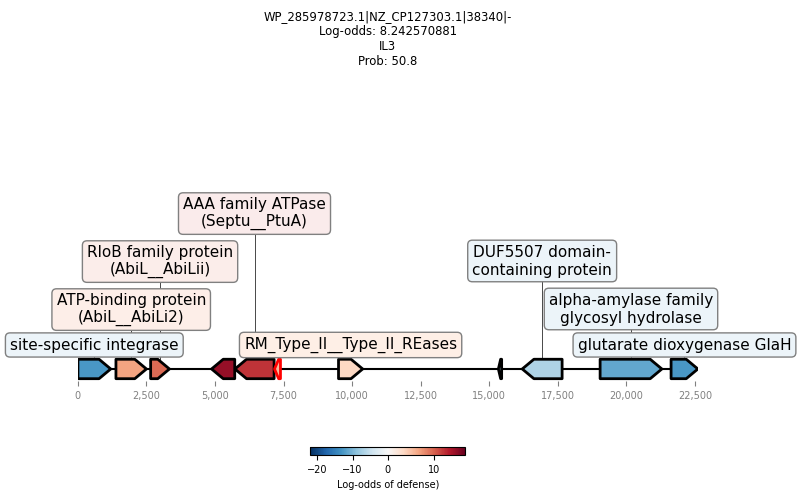

In [39]:
for _, hit in filtered_pfam.iterrows():
    title = '\n'.join([hit['protein_context_id'], f"Log-odds: {str(hit['mean_log_odds'])}", 
                       hit["pfam_name"], f"Prob: {str(hit['Prob'])}"])
    center_row = sorted_predictions.loc[sorted_predictions['protein_context_id'] == hit['protein_context_id'], :].squeeze()
    neighbor_df = sorted_predictions.iloc[(center_row.name - n_neighbors):(center_row.name + n_neighbors + 1), :]
    neighbor_df = neighbor_df[neighbor_df['genomic_accession'] == center_row['genomic_accession']]
    min_start = neighbor_df['start'].min()
    max_end = neighbor_df['end'].max()
    features = list()
    for _, gene in neighbor_df.iterrows():
        start = gene['start'] - min_start
        end = gene['end'] - min_start
        if gene['strand'] == '+':
            strand = 1
        else:
            strand = -1
        if (gene['protein_context_id'] == center_row['protein_context_id']):
            linecolor = 'red'
        else:
            linecolor = 'black'
        if gene['defense_system_protein']:
            label = gene['defense_system_gene']
        elif gene['defense_homolog']:
            if gene['name'] != 'hypothetical protein':
                label = f"{gene['name']} ({gene['defense_homolog_name']})"
            else:
                label = gene['defense_homolog_name']
        elif gene['name'] == 'hypothetical protein':
            label = None
        else:
            label = gene['name']
        color = cmap(norm(gene['mean_log_odds']))
        feature = GraphicFeature(start=start, end=end, strand=strand, linecolor=linecolor, 
                                 label=label, color=color, linewidth=2)
        features.append(feature)
    record = GraphicRecord(sequence_length=(max_end - min_start + 1), features=features)
    _, ax = plt.subplots(figsize=(8, 5))
    record.plot(ax=ax)
    plt.subplots_adjust(bottom=0)
    plt.title(title)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='Log-odds of defense)', ax=ax, location='bottom', shrink=0.25)
    plt.show()